In [1]:
import sys
sys.path.append('../../')
import os
from pathlib import Path
import random


import numpy as np
import pandas as pd
from sklearn import metrics, model_selection
import matplotlib.pyplot as plt
plt.ion()   # interactive mode
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import albumentations as A

from project.infrastructure.model_trainer import Model
from project.infrastructure.img_dataset import ImageDataset
from project.infrastructure.torchsampler import ImbalancedDatasetSampler
import project.infrastructure.utils as utils
import project.infrastructure.pytorch_util as ptu

In [2]:
# not using for now
try:
    from torchsummary import summary
except ImportError:
    pass

try:
    import seaborn as sns
except ImportError:
    pass

try:
    import optuna
except ImportError:
    pass

In [3]:
current_dir = Path.cwd()
home_dir = Path.home()
print(f"current_dir: {current_dir}")
print(f"home_dir:{home_dir}")

current_dir: /home/yiw084/Documents/GitHub/ECE_228-Team-4/project/test
home_dir:/home/yiw084


## Config PATH

In [4]:
# Config data_dir, img_dir
data_dir = Path("../../data/")
leaf_data_dir: str = "cassava-leaf-disease-classification/"
csv_file_name: str = "train.csv"

csv_file_path = data_dir/leaf_data_dir/csv_file_name

In [5]:
img_folder_name: str = "train_images"
img_dir = data_dir/leaf_data_dir/img_folder_name

## Load Data description

In [6]:
df = pd.read_csv(csv_file_path)
print(df.shape)
df.head()

(21397, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
# Noticed that the dataset is unbalanced
# TODO: handle class weight for imbalanced dataset
df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [8]:
# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

if torch.cuda.device_count() > 1:
    torch.cuda.manual_seed_all(SEED)

In [9]:
# set overflow warning to error instead
np.seterr(all='raise')
torch.autograd.set_detect_anomaly(True)

# Enable cuDNN Auto-tuner before launching training loop
# Improve performance (For convolutional networks only!)
torch.backends.cudnn.benchmark = True

## Split data into train and valid (9:1)

In [10]:
'''
While I used train_test_split() to create both a training and validation dataset,
consider exploring cross validation instead.
'''
# Split dataset into train and valid
df_train, df_valid = model_selection.train_test_split(
    df,
    test_size=0.1,
    train_size=0.9,
    random_state=SEED,
    stratify=df.label.values
)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_train.shape, df_valid.shape

((19257, 2), (2140, 2))

In [11]:
df_train.head()

,image_id,label
0,1724663202.jpg,1
1,1443500189.jpg,0
2,3794321240.jpg,3
3,358823158.jpg,3
4,681211585.jpg,4


In [12]:
df_valid.head()

,image_id,label
0,3512385051.jpg,4
1,592844774.jpg,3
2,3547680343.jpg,4
3,41606397.jpg,1
4,2417340627.jpg,2


In [13]:
# Get image path for both training and validation
# Remember to convert path object to str!!
train_img_paths = [str(img_dir/img_id) for img_id in df_train["image_id"].values]
valid_img_paths = [str(img_dir/img_id) for img_id in df_valid["image_id"].values]

# Get image label for both training and validation
train_targets = df_train.label.values
valid_targets = df_valid.label.values

# Verify img paths
train_img_paths[:3], valid_img_paths[:3]

(['../../data/cassava-leaf-disease-classification/train_images/1724663202.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/1443500189.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/3794321240.jpg'],
 ['../../data/cassava-leaf-disease-classification/train_images/3512385051.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/592844774.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/3547680343.jpg'])

In [14]:
train_targets

array([1, 0, 3, ..., 1, 3, 4])

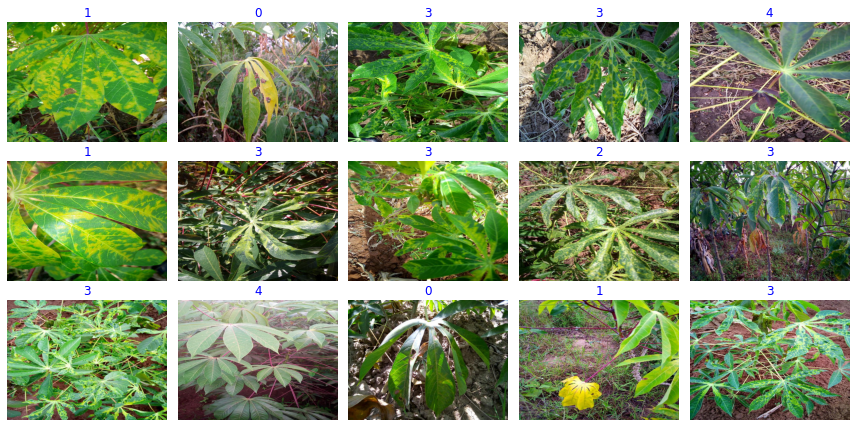

CPU times: user 1.05 s, sys: 161 ms, total: 1.21 s
Wall time: 1.01 s


In [15]:
%%time
# show images
utils.display_image_grid(
    images_filepaths=train_img_paths[0:15],
    predicted_labels=train_targets[0:15]
)

## data_transforms

In [16]:
data_transforms = {
    # Training augmentation
    "train_img_aug": A.Compose(
        [
            A.RandomResizedCrop(width=256, height=256),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(
            shift_limit=(0.2, 0.2), scale_limit=(1.1, 1.1), rotate_limit=(45, 45), p=0.5
            ),
            A.GridDistortion(p=0.5),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    ),

    # Validation augmentation
    "valid_img_aug": A.Compose(
        [
            A.RandomCrop(width=256, height=256, p=1.0),
            A.Resize(width=256, height=256),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
}

## Create dataset

In [17]:
# clear gpu cache to release memory
torch.cuda.empty_cache()

# Create training and validation dataset
train_dataset = ImageDataset(
    image_paths=train_img_paths,
    targets=train_targets,
    augmentations=data_transforms["train_img_aug"]
)

valid_dataset = ImageDataset(
    image_paths=valid_img_paths,
    targets=valid_targets,
    augmentations=data_transforms["valid_img_aug"]
)

print(train_dataset[100], '\n')
print(type(train_dataset[100]))

{'image': tensor([[[ 65.,  70.,  60.,  ...,  70.,  73.,  79.],
         [ 75.,  69.,  65.,  ...,  69.,  70.,  73.],
         [ 77.,  75.,  84.,  ...,  79.,  79.,  81.],
         ...,
         [ 89.,  81.,  74.,  ..., 102., 104., 100.],
         [ 95.,  90.,  82.,  ..., 100.,  98.,  98.],
         [100.,  97.,  86.,  ..., 106., 103.,  96.]],

        [[ 74.,  80.,  70.,  ..., 105., 105., 105.],
         [ 78.,  71.,  65.,  ..., 102., 101., 101.],
         [ 73.,  68.,  72.,  ..., 105., 105., 107.],
         ...,
         [124., 114., 105.,  ..., 112., 117., 115.],
         [131., 122., 111.,  ..., 109., 109., 111.],
         [133., 129., 115.,  ..., 116., 113., 108.]],

        [[ 64.,  70.,  61.,  ...,  81.,  80.,  83.],
         [ 66.,  60.,  55.,  ...,  74.,  74.,  74.],
         [ 61.,  57.,  61.,  ...,  76.,  75.,  76.],
         ...,
         [ 79.,  74.,  70.,  ..., 120., 123., 119.],
         [ 84.,  82.,  77.,  ..., 120., 120., 120.],
         [ 90.,  91.,  84.,  ..., 130., 126

## Note dataloader is implemented inside Model.fit()

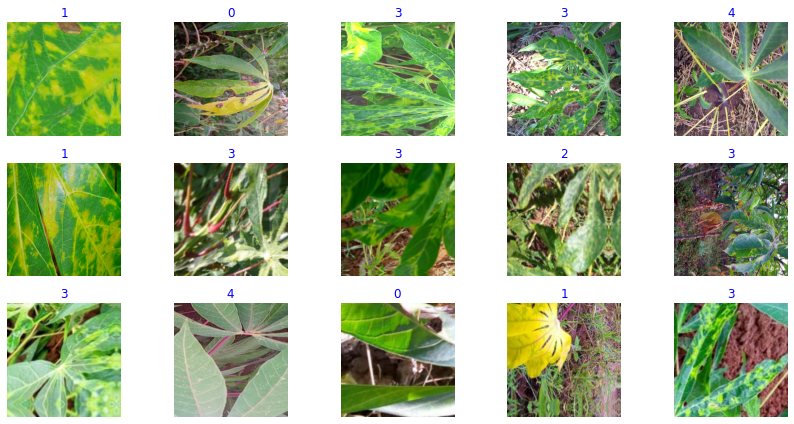

CPU times: user 717 ms, sys: 156 ms, total: 872 ms
Wall time: 588 ms


In [18]:
%%time
# Visualize training images after augmentation
train_images_array_lst = [train_dataset[i]['image'] for i in range(15)]
train_images_label_lst = [train_dataset[i]['target'] for i in range(15)]
utils.display_image_grid(
    images_array_lst=train_images_array_lst,
    true_labels=train_images_label_lst
)

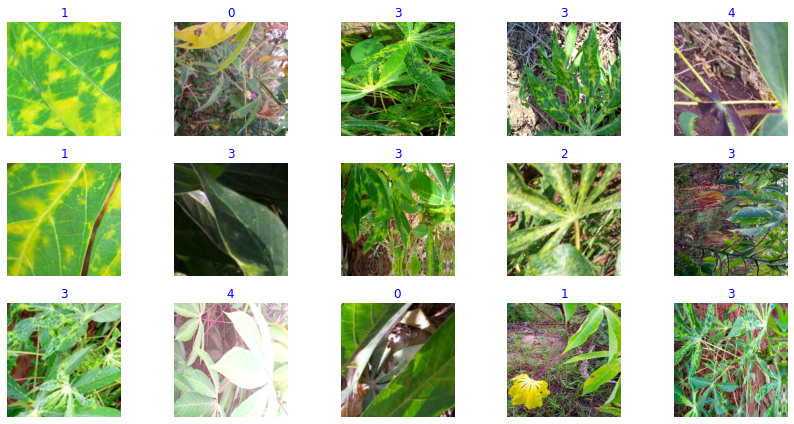

CPU times: user 796 ms, sys: 179 ms, total: 974 ms
Wall time: 677 ms


In [19]:
%%time
# Visualize validation images after augmentation
valid_images_array_lst = [train_dataset[j]['image'] for j in range(15)]
valid_images_label_lst = [train_dataset[j]['target'] for j in range(15)]
utils.display_image_grid(
    images_array_lst=valid_images_array_lst,
    true_labels=valid_images_label_lst
)


## Transfer Learning fo Computer Vision

Quoting these notes from [cs231n](https://cs231n.github.io/transfer-learning/),

In practice, very few people train an entire Convolutional Network from scratch (with random initialization),
because it is relatively rare to have a dataset of sufficient size.
Instead, it is common to pretrain a ConvNet on a very large dataset
(e.g. ImageNet, which contains 1.2 million images with 1000 categories),
and then use the ConvNet either as an initialization, or a fixed feature extractor for the task of interest.

In [20]:
class LeafDiseaseClassifier(Model):
    def __init__(self, params: dict,):
        super().__init__()
        self.params = params
        # default: Finetuning the ConvNet
        self.resnet18 = torchvision.models.resnet18(pretrained=params["pretrained"])

        # # As fixed feature extractor
        # for param in self.resnet18.parameters():
        #     param.requires_grad = False

        self.resnet18.fc = nn.Linear(in_features=512, out_features=params["output_size"], bias=True)

    def config_optimizer(self, *args, **kwargs):
        opt = optim.Adam(self.parameters(), lr=self.params["learning_rate"])
        return opt

    # TODO: config lr_scheduler
    # def config_scheduler(self, *args, **kwargs):
    #     assert self.optimizer is not None, "Please set up optimizer first"
    #     sch = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=30, verbose=False)
    #     return sch

    def config_criterion(self, *args, **kwargs):
        criterion = nn.CrossEntropyLoss()
        return criterion

    def loss_fn(self, outputs, targets=None):
        """ calculate loss """
        if targets is None or self.criterion is None:
            print("Targets is None or Criterion is None")
            return None
        return self.criterion(outputs, targets)

    def forward(self, x):
        out: torch.FloatTensor = self.resnet18(x)
        return out

    def monitor_metrics(self, outputs, targets=None) -> dict:
        predictions: np.ndarray = ptu.to_numpy(torch.argmax(outputs, dim=1))
        targets: np.ndarray = ptu.to_numpy(targets)
        accuracy = metrics.accuracy_score(targets, predictions)
        val_metrics = {
            "acc": accuracy,
        }
        return val_metrics

## Define training parameter

In [21]:
# TODO: change param
print(df.label.unique().shape[0])
# training param
params = {
    "output_size":5,
    "max_epochs": 3,
    "train_batch_size": 8,
    "valid_batch_size": 16*2,
    'fp16': True,
    'seed': 42,
    'no_gpu': False,
    'which_gpu': 0,
    'num_workers': -1,
    'learning_rate': 3e-4,
    'pretrained': True,
    'img_channel': 3,
    'img_height': 256,
    'img_width': 256,
    'save_model': True,
    'logdir': '../../runs/',

}
assert params["output_size"] == df.label.unique().shape[0]

5


## Build NN

In [22]:
# Create ResNet50
resnet18_model:nn.Module = LeafDiseaseClassifier(params)

In [23]:
# Check if NN build successfully
img = train_dataset[0]["image"]
target = train_dataset[0]["target"]
img, target

(tensor([[[157., 158., 159.,  ..., 117., 112., 112.],
          [155., 155., 155.,  ..., 114., 111., 111.],
          [154., 153., 152.,  ..., 111., 111., 111.],
          ...,
          [ 83.,  84.,  85.,  ...,  88.,  92.,  92.],
          [ 84.,  85.,  85.,  ...,  87.,  90.,  90.],
          [ 84.,  85.,  85.,  ...,  87.,  90.,  90.]],
 
         [[202., 203., 204.,  ..., 182., 178., 178.],
          [201., 201., 201.,  ..., 179., 176., 176.],
          [200., 199., 198.,  ..., 177., 177., 177.],
          ...,
          [155., 156., 156.,  ..., 158., 160., 160.],
          [156., 156., 156.,  ..., 157., 158., 158.],
          [156., 156., 156.,  ..., 157., 158., 158.]],
 
         [[ 73.,  75.,  78.,  ...,  99.,  96.,  96.],
          [ 71.,  72.,  73.,  ...,  97.,  97.,  97.],
          [ 68.,  69.,  70.,  ...,  97.,  98.,  98.],
          ...,
          [ 85.,  86.,  86.,  ...,  89.,  90.,  90.],
          [ 86.,  86.,  86.,  ...,  89.,  89.,  89.],
          [ 86.,  86.,  86.,  .

In [24]:
# Build success
resnet18_model(img.unsqueeze(0))


tensor([[ 0.0382,  0.5091, -0.2923,  0.8065,  0.3369]],
       grad_fn=<AddmmBackward>)

## Start training loop

In [25]:
# Init GPU if available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)



cuda:0


In [26]:
# init Trainer
resnet18_model.init_trainer(params)

Using GPU id 0
############ cuda:0: AMP=True ############


In [27]:
%%time
# metrics are store in history: dict
history = resnet18_model.fit(
    train_dataset=train_dataset,
    train_batch_size=params["train_batch_size"],
    valid_dataset=valid_dataset,
    valid_batch_size=params["valid_batch_size"],
    max_epochs=params["max_epochs"],
    device=device,
    train_sampler=None,  #ImbalancedDatasetSampler(train_dataset),
    valid_sampler=None,  #ImbalancedDatasetSampler(valid_dataset),
    num_workers=params["num_workers"], use_fp16=params['fp16'],
    save_best=params['save_model'],
    better_than=0.8
                    
)


Creating Training Dataloader...

Creating Validation Dataloader...


LDC:   0%|          | 0/3 [00:51<?, ?it/s]


KeyboardInterrupt: 

# plot metrics

In [28]:
train_losses = history['train_loss']
val_losses = history['val_loss']
plt.plot(train_losses, '-x')
plt.plot(val_losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of Epochs')
plt.show()



NameError: name 'history' is not defined

In [ ]:
val_acc = np.array(history['acc'])
avg_acc = np.vstack(val_acc).mean(axis=1)
print(avg_acc.shape)
plt.plot(avg_acc, '-x')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Validation Accuracy'])
plt.title('Accuracy vs. No. of Epochs')
plt.show()

# TODO: add confusion_mtx


## TODO: finish optuna automate hyperparam tuning [example](https://github.com/optuna/optuna/blob/master/examples/pytorch/pytorch_simple.py)

In [ ]:
def define_model(trial: optuna.Trial):
    ...
def objective(trial: optuna.Trial):
    # Generate the model
    model=resnet18_model.to(device)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    train_loader, valid_loader = ...


In [ ]:
"""
study = optuna.create_study(direction=)
study.optimize(objective(), n_trials=..., timeout=600)
"""

In [ ]:
# clear gpu cache to release memory
torch.cuda.empty_cache()
